# Final Project: Sentiment Analysis of Movie Reviews

# Introduction

This notebook represents the Data Science part of the sentiment analysis project. The objective is to develop a model capable of classifying movie reviews into negative or positive sentiments. The best model identified in this notebook will serve as the foundation for a standalone application, which will be containerized using Docker.

A note for clarity: Throughout this notebook (and the entire project), terms such as "tokens," "features," or "words" will be used interchangeably, as will "review/document" and "target/sentiment" or "corpus/dataset."

# Importing Libraries and Training Dataset

In [1]:
import re
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [2]:
df = pd.read_csv('../data/raw/train/train.csv')

# Auxiliary Methods

In [3]:
# Method is to obtain decriptive statistics on the dataset in terms of min, max, average, and frequencies for each label
def analyze_reviews(data, preprocessed=False, most_common=20, least_common=None, display_statistics=True):
    if not preprocessed:
        tokens_list = data['review'].apply(word_tokenize).tolist()
    else:
        tokens_list = data['review'].str.split().tolist()
    all_tokens = [token for sublist in tokens_list for token in sublist]
    total_unique_features = len(set(all_tokens))
    word_counts = [len(tokens) for tokens in tokens_list]
    min_features = min(word_counts)
    max_features = max(word_counts)
    avg_features = sum(word_counts) / len(word_counts)
    median_features = sorted(word_counts)[len(word_counts) // 2]
    doc_frequency = defaultdict(int)
    for tokens in tokens_list:
        unique_tokens = set(tokens)
        for token in unique_tokens:
            doc_frequency[token] += 1
    unique_in_one_document = sum(1 for word in doc_frequency if doc_frequency[word] == 1)

    if display_statistics:
      print(f"Total Unique Features: {total_unique_features}")
      print(f"Min Number of Features: {min_features}, Max Number of Features: {max_features}")
      print(f"Average Number of Features: {avg_features:.2f}, Median Number of Features: {median_features}")
      print(f"Number of features that appear in only one document: {unique_in_one_document}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    colors = {'positive': 'green', 'negative': 'red'}
    for i, label in enumerate(['positive', 'negative']):
        label_tokens = [token for j, tokens in enumerate(tokens_list) if data['sentiment'].iloc[j] == label for token in tokens]
        freq_dist = FreqDist(label_tokens)
        common_words = freq_dist.most_common(most_common)
        words, counts = zip(*common_words)
        axes[i].bar(words, counts, color=colors[label])
        axes[i].set_title(f"{most_common} Most Common Features in {label.capitalize()} Reviews")
        axes[i].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

    if least_common:
        least_common_words_df = pd.DataFrame()
        for label in ['positive', 'negative']:
            label_tokens = [token for j, tokens in enumerate(tokens_list) if data['sentiment'].iloc[j] == label for token in tokens]
            freq_dist = FreqDist(label_tokens)
            least_common_words = freq_dist.most_common()[:-least_common-1:-1]
            least_common_words_df[label] = [word for word, count in least_common_words]
        print(f"\n{least_common} Least Common Words in Each Class:")
        display(least_common_words_df)

In [4]:
# Method to plot preprocessed (but not vectorized) data to compare stemming and lemmatization
def plot_clean_data(data, use_lemmatization=False, row_number = 9):
    start_time = time.time()
    preprocessor = TextPreprocessor(use_lemmatization=use_lemmatization, vectorization_type=None)
    X, y, _ = preprocessor.preprocess(data)
    elapsed_time = time.time() - start_time
    preprocessed_df = pd.DataFrame({'review': X, 'sentiment': y.map({0: 'negative', 1: 'positive'})})
    print(f"Time taken for preprocessing: {elapsed_time:.2f} seconds")
    analyze_reviews(preprocessed_df, most_common=30, preprocessed=True)
    reviews_df = pd.DataFrame({
        "Original Review": [data['review'].iloc[row_number]],
        "Cleaned Review": [preprocessed_df['review'].iloc[row_number]]
    })
    return reviews_df.style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

In [5]:
# Method to process data in four different ways
def prepare_datasets(data_train, data_test):
    combinations = [
        (True, "ngrams"),
        (False, "ngrams"),
        (True, "tf-idf"),
        (False, "tf-idf")
    ]
    results = {}
    for use_lemmatization, vectorization_type in combinations:
        start_time = time.time()
        preprocessor = TextPreprocessor(use_lemmatization=use_lemmatization, vectorization_type=vectorization_type)
        X_train, y_train, vectorizer = preprocessor.preprocess(data_train, fit_vectorizer=True)
        X_test, y_test, _ = preprocessor.preprocess(data_test, fit_vectorizer=False)
        elapsed_time = time.time() - start_time
        key = f"Lemmatization={use_lemmatization}, Vectorization={vectorization_type}"
        results[key] = {
            "time_taken": elapsed_time,
            "train_shape": X_train.shape,
            "test_shape": X_test.shape,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "vectorizer": vectorizer
        }
    return results

In [6]:
# Method to extract processed data
def extract_prepared_data(prepared_data, lemmatization, vectorization):
    base_key = f'Lemmatization={lemmatization}, Vectorization={vectorization}'
    data_dict = prepared_data[base_key]
    return (data_dict['X_train'], data_dict['y_train'], 
            data_dict['X_test'], data_dict['y_test'], data_dict['vectorizer'])

In [7]:
# Methos to obtain most common words in vectorized data for each label
def plot_vectorized_data(X, y, vectorizer, top_n=30):
    X = X.tocsc() if not isinstance(X, np.ndarray) else X
    classes = [(1, 'green', 'Positive Class'), (0, 'red', 'Negative Class')]
    feature_names = vectorizer.get_feature_names_out()
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    for idx, (class_label, color, title) in enumerate(classes):
        class_data = X[y == class_label]
        sum_words_class = class_data.sum(axis=0)
        top_words_class = sorted([(feature_names[i], sum_words_class[0, i]) for i in range(class_data.shape[1])], 
                                 key=lambda x: x[1], reverse=True)[:top_n]
        axes[idx].bar([word[0] for word in top_words_class], [word[1] for word in top_words_class], color=color)
        axes[idx].set_title(f'Top 30 Most Common/Important Features in {title}')
        axes[idx].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

In [8]:
# Method to obtain most common bigrams and trigrams for each label
def top_bigrams_trigrams(X, y, vectorizer, top_n=5):
    def filter_ngrams(feature_names, n):
        return [f for f in feature_names if len(f.split()) == n]

    def top_ngrams(class_data, n):
        sum_words = class_data.sum(axis=0) 
        ngrams = filter_ngrams(feature_names, n)
        ngrams_idx = [vectorizer.vocabulary_.get(ng) for ng in ngrams]
        ngrams_freq = {ngrams[i]: sum_words[0, idx] for i, idx in enumerate(ngrams_idx) if idx is not None}
        sorted_ngrams = sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
        return [ng[0] for ng in sorted_ngrams]
    
    X = X.tocsc() if not isinstance(X, np.ndarray) else X
    feature_names = vectorizer.get_feature_names_out()
    top_ngrams_df = pd.DataFrame(columns=['Class', 'Bigrams', 'Trigrams'])
    for class_label in [1, 0]:
        class_data = X[y == class_label]
        class_name = 'Positive' if class_label == 1 else 'Negative'
        top_bigrams = top_ngrams(class_data, 2)
        top_trigrams = top_ngrams(class_data, 3)
        top_ngrams_df = top_ngrams_df.append({'Class': class_name, 
                                              'Bigrams': ', '.join(top_bigrams), 
                                              'Trigrams': ', '.join(top_trigrams)}, 
                                             ignore_index=True)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)    
    return top_ngrams_df

In [9]:
# Method to streamline training and evaluation over four different datasets
def train_and_evaluate_model(model, datasets=None, X_train=None, y_train=None, X_test=None, y_test=None):
    results = {}
    if datasets:
        for key, data in datasets.items():
            X_train, y_train, X_test, y_test = data['X_train'], data['y_train'], data['X_test'], data['y_test']
            results[key] = run_model(model, X_train, y_train, X_test, y_test)
    else:
        if None in (X_train, y_train, X_test, y_test):
            raise ValueError("When not using datasets dictionary, all individual train-test sets must be provided.")
        key = "Custom Train-Test Set"
        results[key] = run_model(model, X_train, y_train, X_test, y_test)
    return results

# Method to train and evaluate a model on a dataset
def run_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {
        "train_time": train_time,
        "train_accuracy": model.score(X_train, y_train),
        "test_accuracy": accuracy,
        "test_f1": f1
    }

In [10]:
# Method to tune hyperparameters using gridsearch
def perform_gridsearch(model, param_grid, X_train, y_train, X_test, y_test):
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    best_index = grid_search.best_index_
    for i in range(5):
        fold_accuracy = grid_search.cv_results_[f'split{i}_test_score'][best_index]
        print(f"Accuracy for fold {i+1}: {fold_accuracy:.4f}")
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1_score = f1_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    try:
        test_aucroc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
    except AttributeError:
        test_aucroc = roc_auc_score(y_test, grid_search.decision_function(X_test))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
    print(f"Test AUC ROC score: {test_aucroc:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [11]:
# Method to plot top n features for a given model
def plot_feature_importances(model, vectorizer, top_n=20):
    is_linear_model = hasattr(model, 'coef_')
    if is_linear_model:
        importances = model.coef_.ravel()
        # For linear models, we can have both positive and negative features
        top_positive_indices = np.argsort(importances)[-top_n:][::-1]
        top_negative_indices = np.argsort(importances)[:top_n]
        top_indices = np.hstack([top_positive_indices, top_negative_indices[::-1]])
        title = f'Top {top_n} Positive and Negative Feature Importances in the Linear Model'
    else:
        importances = model.feature_importances_
        # For tree-based models, only positive features are relevant
        top_indices = np.argsort(importances)[-top_n:][::-1]
        title = f'Top {top_n} Feature Importances in the Tree-Based Model'
    top_features = vectorizer.get_feature_names_out()[top_indices]
    top_importances = importances[top_indices]
    plt.figure(figsize=(10, top_n/2))
    colors = ['green' if c > 0 else 'red' for c in top_importances] if is_linear_model else 'blue'
    plt.barh(np.arange(len(top_indices)), top_importances, color=colors)
    plt.yticks(np.arange(len(top_indices)), top_features)
    plt.xlabel('Importance Value' if not is_linear_model else 'Coefficient Value')
    plt.title(title)
    plt.axvline(x=0, color='k', linestyle='--') if is_linear_model else None
    plt.gca().invert_yaxis()
    plt.show()

# EDA

To start off, let's take a sneak peak at the raw dataset. In the notebook we will only be working with the training data (train.csv).

In [12]:
display(df.head(10), df.info(), df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative
5,Opera (the U.S. title is terror at the opera) ...,positive
6,Heard about this film a long while ago and fin...,positive
7,"John Holmes is so famous, he's infamous (as th...",positive
8,What is worth mentioning that is omitted in th...,positive
9,Darling Lili is fantastic! Its by far one my f...,positive


None

review       0
sentiment    0
dtype: int64

The training dataset comprises 40,000 reviews, without missing values. The initial inspection of the dataset reveals special characters, contractions, and proper nouns, all of which should be addressed during data preprocessing to improve the quality of the analysis.

Let's check class distribution among the target labels

In [13]:
df['sentiment'].value_counts()

positive    20000
negative    20000
Name: sentiment, dtype: int64

The reviews are equally split between positive and negative sentiments.

Next, let's check for duplicates.

In [14]:
df.duplicated().sum()

272

In [15]:
df.drop_duplicates(inplace=True)

We have eliminated 272 duplicate entries. This is a comparatively minor fraction of the data, so its removal is unlikely to significantly disrupt the balance between the target classes—even if all duplicates were from the same class.

Lastly, let's examine feature distribution in the corpus. We will check the total number of tokens, the range of feature occurrences per document, and identify both the most and least common words by sentiment. This analysis may uncover additional text cleaning requirements.

Total Unique Features: 172303
Min Number of Features: 9, Max Number of Features: 2911
Average Number of Features: 279.82, Median Number of Features: 209
Number of features that appear in only one document: 93648


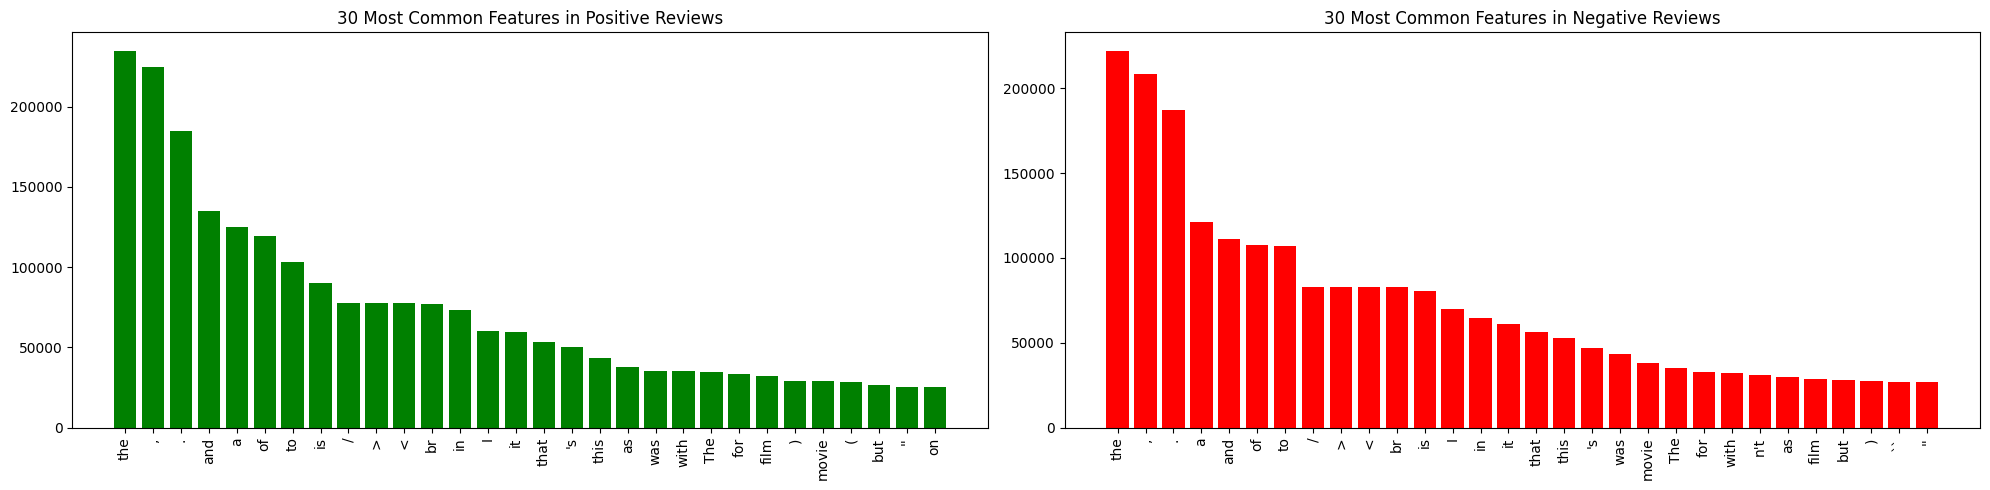


15 Least Common Words in Each Class:


,positive,negative
0,Morning.,crap.the
1,Whoo,with.it
2,Recommends,twins.
3,Criteria,hackneyed.
4,Late-Nineties,aggressive.
5,Farther,Sneakpreview
6,Gonsalves,whooshing
7,throw-caution-to-the-wind,Lookin
8,somberness,Hitched
9,less-than-honorable,Gettin


In [16]:
analyze_reviews(df, preprocessed=False, most_common=30, least_common=15)

* The corpus is saturated with special characters, HTML tags, and stop words that must be stripped to accurately isolate words indicative of positive or negative sentiments.
* The appearance of both "the" and "The" suggests a need for case normalization prior to stop word removal to ensure consistency.
* A significant proportion—over half—of the features are "least common," appearing only once in the corpus. This is largely attributed to the use of special characters and capitalization.
* The occurrence of some least common words (that appear only once in the entire dataset) can be ascribed to misspellings, as evidenced by terms like "obbsessed" and "reecommend". Ideally, spell-checking should be implemented to reduce the volume of unique features and improve data quality. However spell-checking is a heavy algorithm, and for this dataset it will take hours (if not days) to check and correct spelling on the entire dataset.

# Data Preprocessing

The data will undergo the following preprocessing steps:

* Splitting into X (reviews) and y (sentiment). The latter is numerically encoded (1 for positive, 0 for negative).
* Expansion of negating contractions (e.g. "didn't" becomes "did not"). This step will be necessary for the proper stop-word removal.
* Removal of URLs
* Removal of HTML tags
* Removal of contractions ('ve, 'd, 'll, 'm , etc.)
* Tokenization
* Removal of proper nouns
* Removal of special characters
* Removal of numbers
* Conversion to lower case
* Removal of stop words from the English NLTK library (excluding for "not"). The word "not" is preserved in the corpus since it may be pointing at a negative sentiment (e.g. so that in a review saying "I did not like this movie", the words "not", "like" and "movie" would remain after removal of stop words).
* Removal of words with length of 2 or less characters
* Removal of rare words (that appear only once in the entire training corpus). It may make more sense to spell check those rare words first, but it will take several hours to do that since we have tens of thousands of rare words. 
* Stemming or lemmatization
* Vectorization: n-grams or TF-IDF. For n-grams, I chose the range to include unigrams, bigrams, and trigrams. 

These steps are applied to both train and test data. Four sets of train-test data will be prepared with varying parameters:
* Lemmatization with trigram vectorization
* Lemmatization with TF-IDF vectorization
* Stemming with trigram vectorization
* Stemming with TF-IDF vectorization

To assess the impact of stemming versus lemmatization, as well as different vectorization techniques, I will present the shapes of the preprocessed datasets, samples of preprocessed text, and—during the modeling phase—compare these preprocessing methods in terms of model performance and training duration.

In [17]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

In [18]:
class TextPreprocessor:
    def __init__(self, use_lemmatization=True, vectorization_type=None):
        self.use_lemmatization = use_lemmatization
        self.vectorization_type = vectorization_type
        self.stop_words = set(stopwords.words('english')) - {'not'}
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if not use_lemmatization else None
        self.vectorizer = None
        self.rare_words = None
        # Define a dictionary for contraction expansions
        self.contraction_mapping = {
            r"\bdidn't\b": "did not", r"\bdon't\b": "do not",
            r"\bwasn't\b": "was not", r"\bisn't\b": "is not",
            r"\bweren't\b": "were not", r"\bare't\b": "are not",
            r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
            r"\bcouldn't\b": "could not", r"\bcan't\b": "can not",
            r"\bain't\b": "am not", r"\bdoesn't\b": "does not",
            r"\bshouldn't\b": "should not", r"\bhadn't\b": "had not",
            r"\bhaven't\b": "have not", r"\bhasn't\b": "has not",
            r"\bmustn't\b": "must not"
        }

    def preprocess(self, data, fit_vectorizer=False):
        if 'sentiment' in data.columns:
            y = data['sentiment'].map({'negative': 0, 'positive': 1})
        else:
            y = None
        
        if self.rare_words is None:
            self._calculate_rare_words(data['review'])

        X_cleaned = data['review'].apply(self._clean_text)

        if self.vectorization_type and fit_vectorizer:
            self.vectorizer = self._get_vectorizer()
            X_vectorized = self.vectorizer.fit_transform(X_cleaned)
        elif self.vectorization_type:
            X_vectorized = self.vectorizer.transform(X_cleaned)
        else:
            X_vectorized = X_cleaned

        return X_vectorized, y, self.vectorizer if fit_vectorizer else None

    def _get_vectorizer(self):
        if self.vectorization_type.lower() == 'ngrams':
            return CountVectorizer(ngram_range=(1, 3), stop_words=list(self.stop_words))
        elif self.vectorization_type.lower() == 'tf-idf':
            return TfidfVectorizer(stop_words=list(self.stop_words))
        else:
            raise ValueError("Invalid vectorization type specified.")

    def _initial_preprocess(self, text):
        # Expand contractions, case-insensitive
        for contraction, expanded in self.contraction_mapping.items():
            text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"(n't|'d|'ll|'m|'re|'s|'ve|')", '', text, flags=re.IGNORECASE)
        tokens = word_tokenize(text)
        tokens = [word for word, pos in pos_tag(tokens) if pos not in ['NNP', 'NNPS']]
        tokens = [re.sub(r'\W+', ' ', word) for word in tokens if not word.isnumeric()]
        return [word.lower() for word in tokens]

    def _calculate_rare_words(self, reviews):
        all_words = [word for review in reviews for word in self._initial_preprocess(review)]
        word_counts = Counter(all_words)
        self.rare_words = {word for word, count in word_counts.items() if count == 1}

    def _clean_text(self, text):
        tokens = self._initial_preprocess(text)
        tokens = [word for word in tokens if word not in self.rare_words and word not in self.stop_words and len(word) > 2]

        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)

## Lemmatization vs Stemming

Time taken for preprocessing: 351.44 seconds
Total Unique Features: 20762
Min Number of Features: 1, Max Number of Features: 969
Average Number of Features: 103.53, Median Number of Features: 78
Number of features that appear in only one document: 694


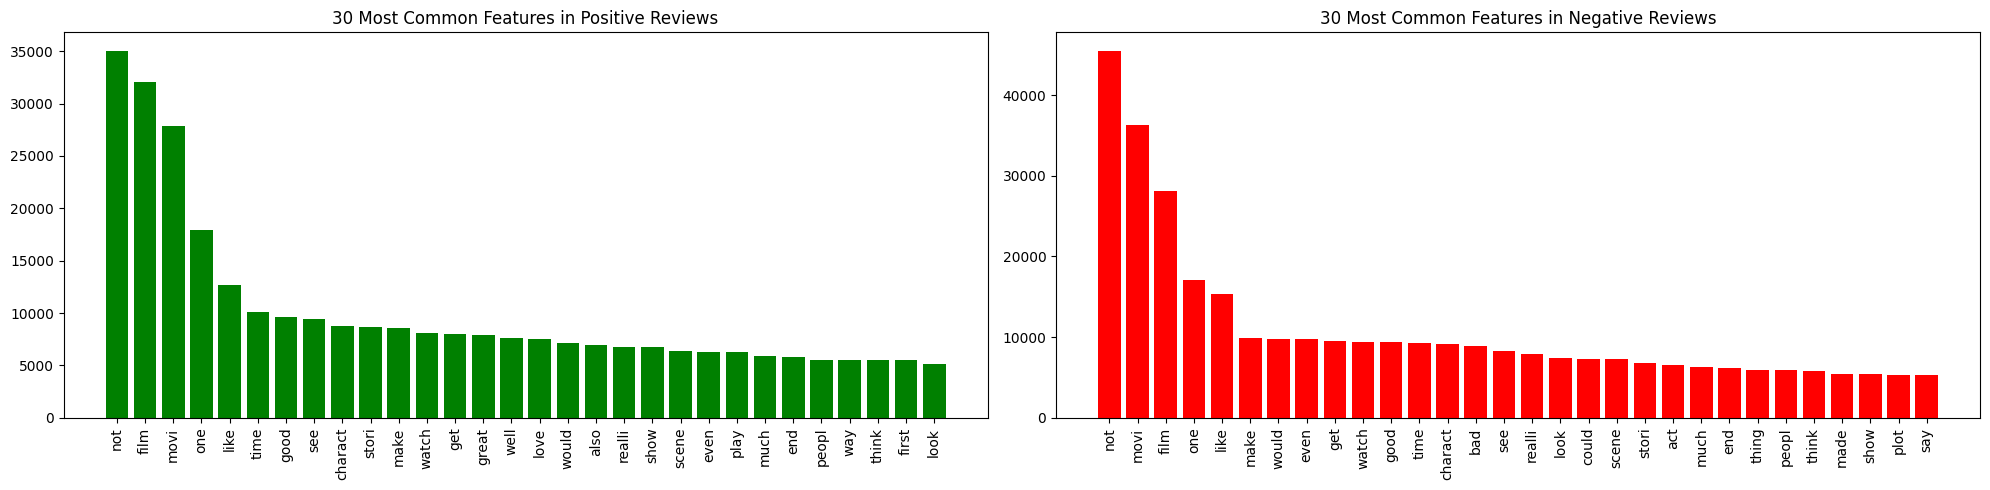

,Original Review,Cleaned Review
0,"I really love anything done by Savage Steve Holland, the writer/director of this great movie. Also see ""Better Off Dead"" and ""How I Got Into College."" Wonderful! Anyway this movie is really humorous and delivers some unexpected things. Where else but in this movie can you see Demi Moore as a talented singer and Bobcat Golthwait as a twin? I recommend this to anybody looking for some old fashioned slapstick comedy (George with the turtle raft), not to mention some really well written sarcasm (the Christmas tree on the roof of the car). This movie constantly throws you unexpected things even after you've seen it 100 times like I have! Enjoy!",realli love anyth done writer director great movi also see got wonder anyway movi realli humor deliv unexpect thing els movi see talent singer twin recommend anybodi look old fashion slapstick comedi turtl raft not mention realli well written sarcasm tree roof car movi constantli throw unexpect thing even seen time like enjoy


In [19]:
plot_clean_data(train, use_lemmatization=False, row_number=5)

Time taken for preprocessing: 324.47 seconds
Total Unique Features: 30853
Min Number of Features: 1, Max Number of Features: 969
Average Number of Features: 103.53, Median Number of Features: 78
Number of features that appear in only one document: 786


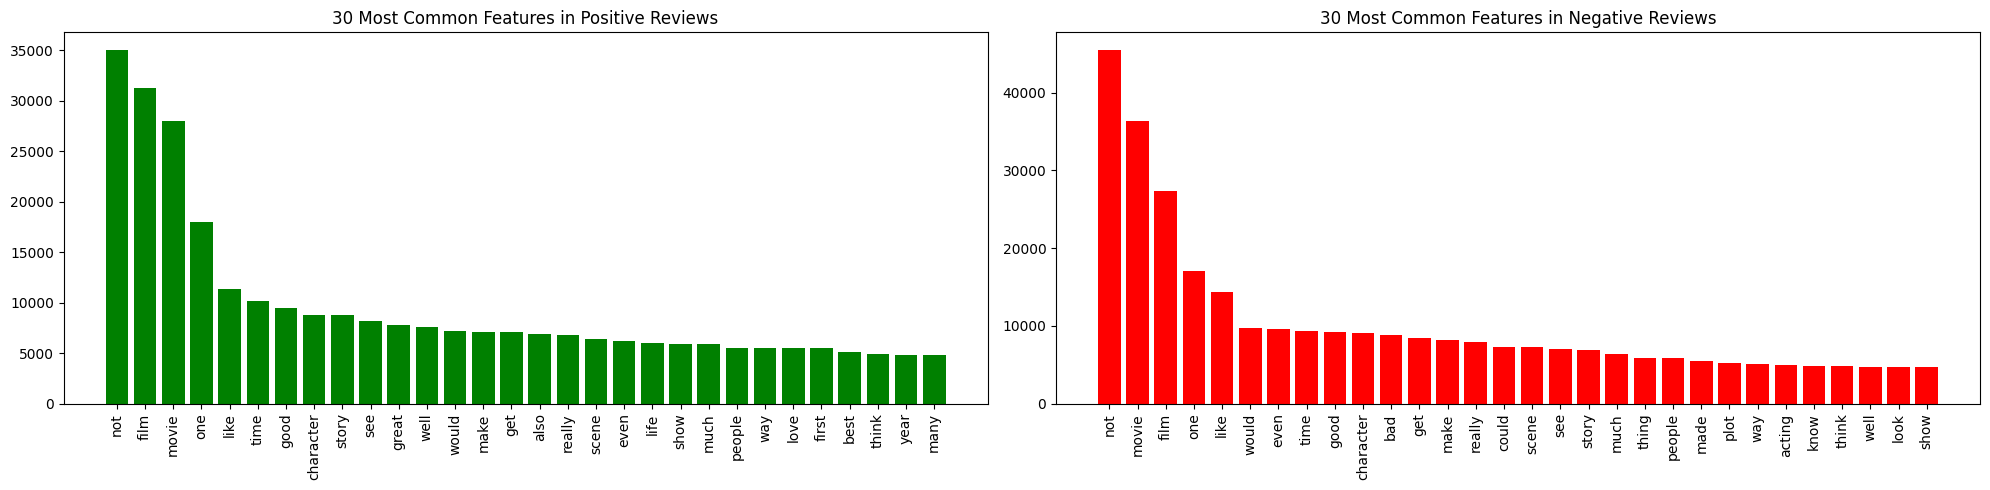

,Original Review,Cleaned Review
0,"I really love anything done by Savage Steve Holland, the writer/director of this great movie. Also see ""Better Off Dead"" and ""How I Got Into College."" Wonderful! Anyway this movie is really humorous and delivers some unexpected things. Where else but in this movie can you see Demi Moore as a talented singer and Bobcat Golthwait as a twin? I recommend this to anybody looking for some old fashioned slapstick comedy (George with the turtle raft), not to mention some really well written sarcasm (the Christmas tree on the roof of the car). This movie constantly throws you unexpected things even after you've seen it 100 times like I have! Enjoy!",really love anything done writer director great movie also see got wonderful anyway movie really humorous delivers unexpected thing else movie see talented singer twin recommend anybody looking old fashioned slapstick comedy turtle raft not mention really well written sarcasm tree roof car movie constantly throw unexpected thing even seen time like enjoy


In [20]:
plot_clean_data(train, use_lemmatization=True, row_number=5)

* Stemmed dataset has less features than the lemmatized one: 22395 vs. 33349. 
* Stemming took longer to preprocess the training data than lemmatization
* The top 30 common words are pretty much the same between the two appraoches except for certain words: like "watch", "life", "way". These words have different order of appearance in the top common words despite being unaffected by stemming or lemmatization (the spelling has been preserved)
* Stemming produced words that don't exist (as expected): stori, charact, realli, etc.

## N- Grams vs TF-IDF

In [21]:
prepared_data = prepare_datasets(train, test)

for key, value in prepared_data.items():
    print(f"{key}: Time taken - {value['time_taken']:.2f} seconds, Train set shape - {value['train_shape']}, Test set shape - {value['test_shape']}")

Lemmatization=True, Vectorization=ngrams: Time taken - 380.23 seconds, Train set shape - (31782, 4575415), Test set shape - (7946, 4575415)
Lemmatization=False, Vectorization=ngrams: Time taken - 414.48 seconds, Train set shape - (31782, 4335322), Test set shape - (7946, 4335322)
Lemmatization=True, Vectorization=tf-idf: Time taken - 369.51 seconds, Train set shape - (31782, 30703), Test set shape - (7946, 30703)
Lemmatization=False, Vectorization=tf-idf: Time taken - 401.97 seconds, Train set shape - (31782, 20616), Test set shape - (7946, 20616)


* Again we see that stemming requires more time than lemmatization
* Utilizing n-grams (spanning unigrams, bigrams, and trigrams) slightly increases the preprocessing time and significantly increases the dimensionality of the dataset

In [22]:
X_train_lemma_ngrams, y_train_lemma_ngrams, X_test_lemma_ngrams, y_test_lemma_ngrams, vectorizer_lemma_ngrams = extract_prepared_data(prepared_data, True, 'ngrams')
X_train_lemma_tfidf, y_train_lemma_tfidf, X_test_lemma_tfidf, y_test_lemma_tfidf, vectorizer_lemma_tfidf = extract_prepared_data(prepared_data, True, 'tf-idf')
X_train_stem_ngrams, y_train_stem_ngrams, X_test_stem_ngrams, y_test_stem_ngrams, vectorizer_stem_ngrams = extract_prepared_data(prepared_data, False, 'ngrams')
X_train_stem_tfidf, y_train_stem_tfidf, X_test_stem_tfidf, y_test_stem_tfidf, vectorizer_stem_tfidf = extract_prepared_data(prepared_data, False, 'tf-idf')

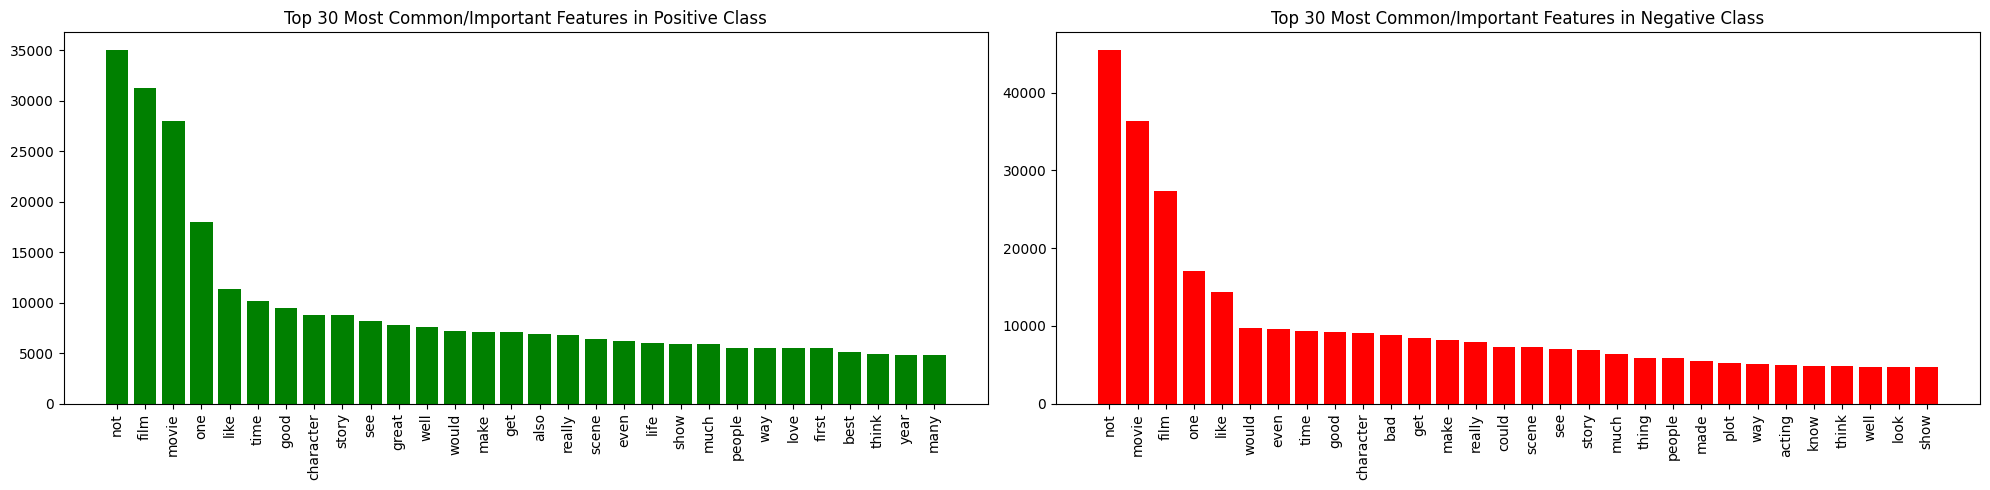

In [23]:
plot_vectorized_data(X_train_lemma_ngrams, y_train_lemma_ngrams, vectorizer_lemma_ngrams)

In [24]:
top_bigrams_trigrams(X_train_lemma_ngrams, y_train_lemma_ngrams, vectorizer_lemma_ngrams)

,Class,Bigrams,Trigrams
0,Positive,"movie not, film not, one best, not know, could not","movie ever seen, one best movie, film ever made, one best film, best movie ever"
1,Negative,"not even, movie not, could not, look like, film not","worst movie ever, movie ever seen, not waste time, worst film ever, one worst movie"


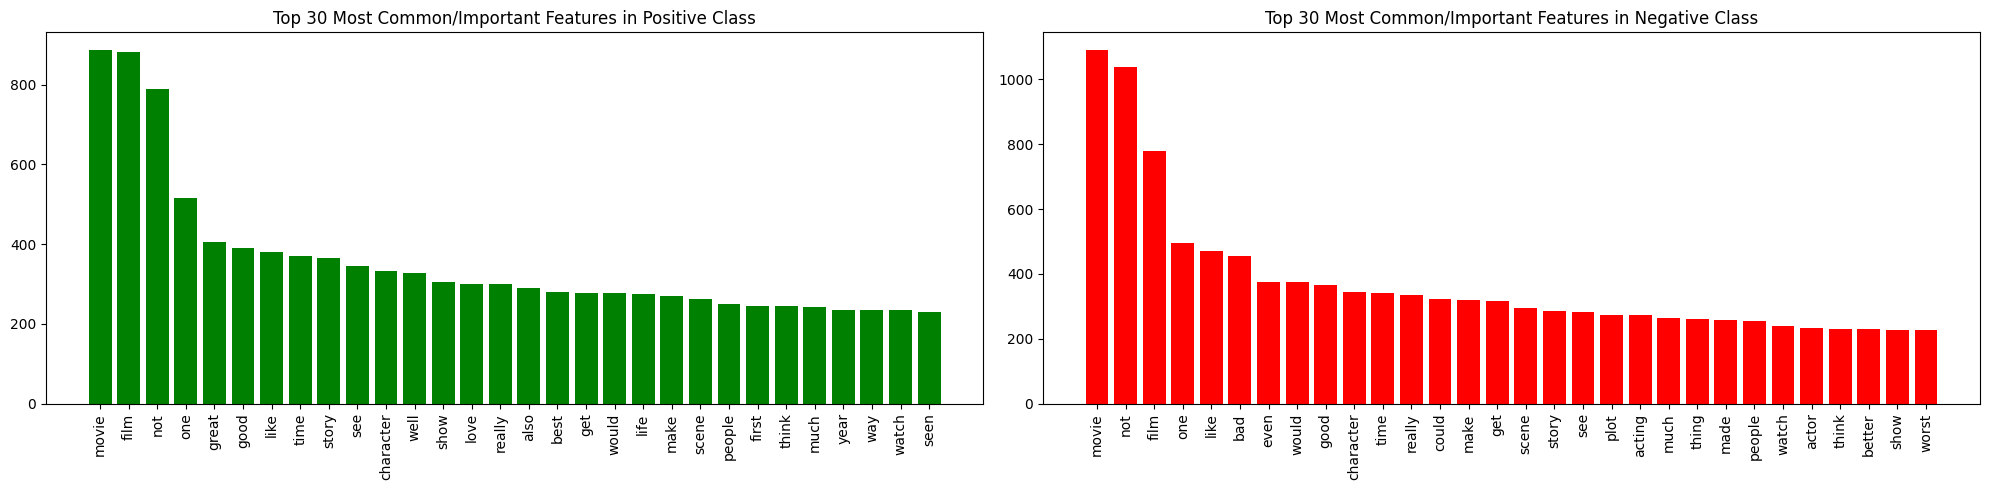

In [25]:
plot_vectorized_data(X_train_lemma_tfidf, y_train_lemma_tfidf, vectorizer_lemma_tfidf)

* Different vectorization approaches yield different ranks of most important or common features. This is because feature importances are calculated differently. 

# Modeling

Here we will explore some of the common classification algorithms on the four datasets we have just created:
* Logistic Regression
* Linear SVC 
* Random Forest
* CatBoost

Since we have large data, some of these algorithms may take hours to build the baseline model, let alone perform cross-validation and hyperparameter tuning. Therefore, I will tune hyperparameters only on the best dataset out of the four and only for those algorithms, which perform the best and which converge relatively fast (within a few minutes). 

## Linear SVC

In [26]:
linear_svc_results = train_and_evaluate_model(LinearSVC(random_state=42, max_iter=5000), datasets=prepared_data)

for key, value in linear_svc_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, " 
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 6.71 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8903, Test F1 Score: 0.8920
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 7.46 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8875, Test F1 Score: 0.8892
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 0.22 seconds, Train Accuracy: 0.9729, Test Accuracy: 0.8806, Test F1 Score: 0.8821
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 0.22 seconds, Train Accuracy: 0.9597, Test Accuracy: 0.8799, Test F1 Score: 0.8818


In [27]:
def linear_svc_gridsearch(X_train, y_train, X_test, y_test):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1],
        'loss': ['hinge', 'squared_hinge']
    }
    linear_svc = LinearSVC(random_state=42, max_iter=5000)
    perform_gridsearch(linear_svc, param_grid, X_train, y_train, X_test, y_test)

In [28]:
linear_svc_gridsearch(X_train_lemma_ngrams, y_train_lemma_ngrams, X_test_lemma_ngrams, y_test_lemma_ngrams)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 0.01, 'loss': 'squared_hinge'}
Best cross-validation accuracy: 0.8891
Accuracy for fold 1: 0.8902
Accuracy for fold 2: 0.8806
Accuracy for fold 3: 0.8960
Accuracy for fold 4: 0.8845
Accuracy for fold 5: 0.8940
Test Accuracy: 0.8928, Test F1 Score: 0.8946
Test Precision: 0.8824, Test Recall: 0.9072
Test AUC ROC score: 0.9549
Confusion Matrix:
[[3479  482]
 [ 370 3615]]


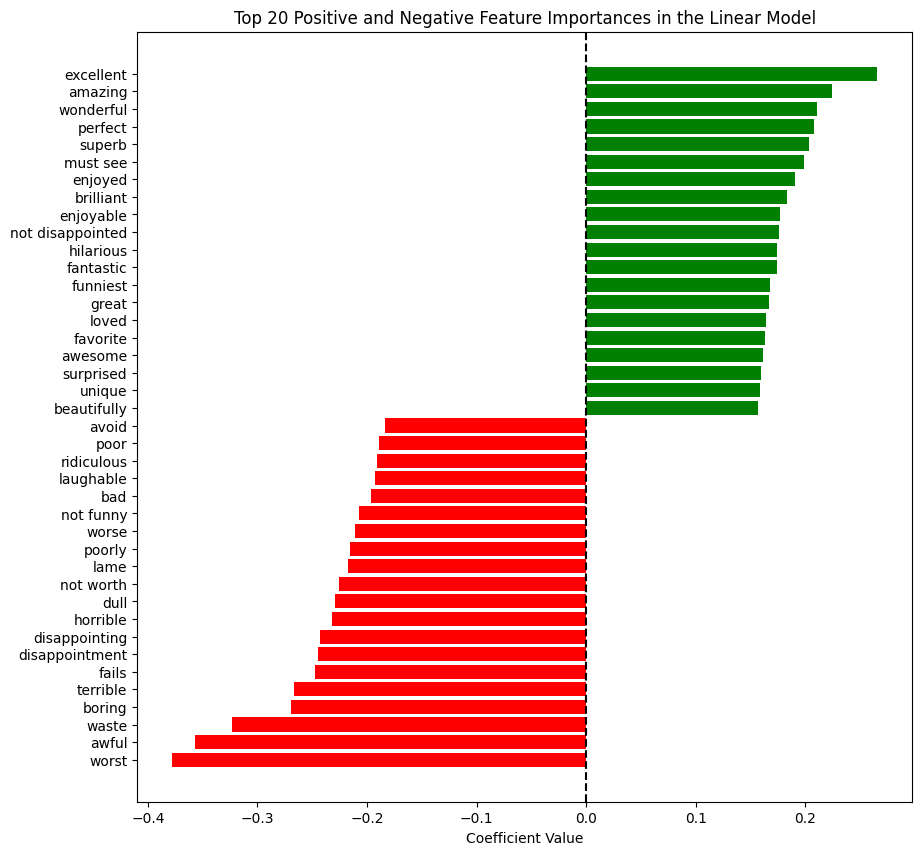

In [29]:
lsvc_model = LinearSVC(random_state=42, C=0.01, max_iter=5000).fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(lsvc_model, vectorizer_lemma_ngrams, top_n=20)

## Logistic Regression

In [30]:
log_reg_results = train_and_evaluate_model(LogisticRegression(random_state=42, max_iter=5000), datasets=prepared_data)

for key, value in log_reg_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, " 
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 76.66 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8916, Test F1 Score: 0.8933
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 75.28 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8911, Test F1 Score: 0.8929
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 0.52 seconds, Train Accuracy: 0.9224, Test Accuracy: 0.8864, Test F1 Score: 0.8880
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 0.32 seconds, Train Accuracy: 0.9146, Test Accuracy: 0.8862, Test F1 Score: 0.8878


In [31]:
def log_reg_gridsearch(X_train, y_train, X_test, y_test):
    param_grid = {
        'C': [1, 10, 100],
        'solver': ['saga', 'lbfgs']
    }
    log_reg = LogisticRegression(random_state=42, max_iter=5000)
    perform_gridsearch(log_reg, param_grid, X_train, y_train, X_test, y_test)

In [32]:
log_reg_gridsearch(X_train_lemma_ngrams, y_train_lemma_ngrams, X_test_lemma_ngrams, y_test_lemma_ngrams)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


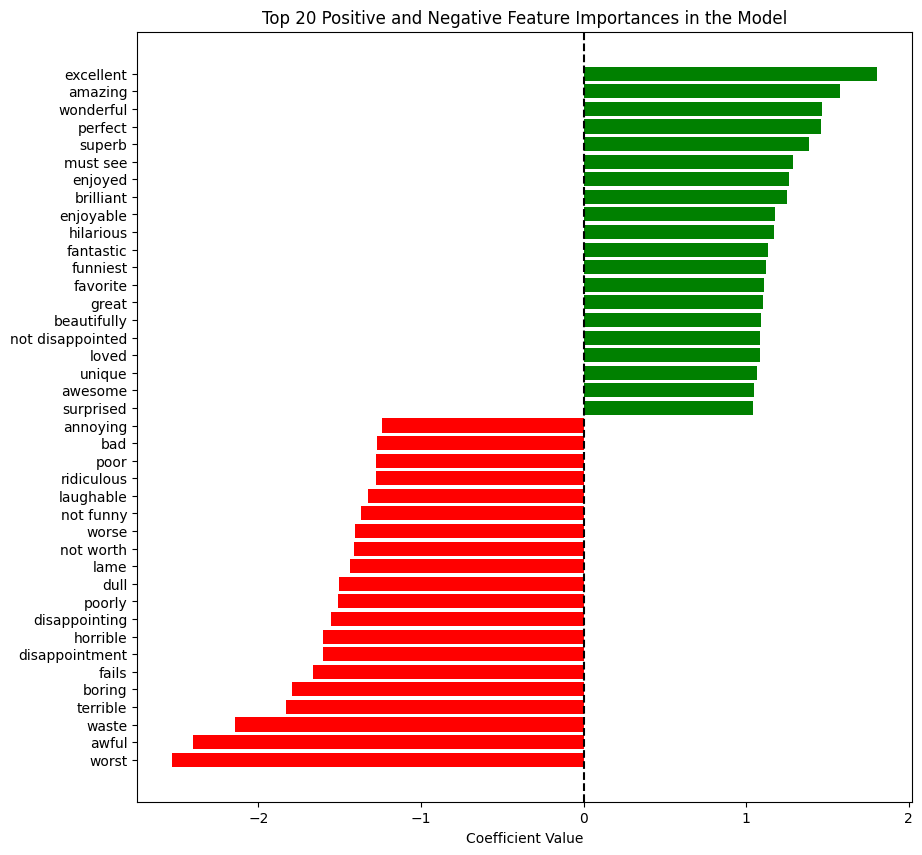

In [ ]:
logreg_model = LogisticRegression(random_state=42, C=100, max_iter=5000, solver='saga').fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(logreg_model, vectorizer_lemma_ngrams, top_n=20)

## Random Forest

In [ ]:
rf_results = train_and_evaluate_model(RandomForestClassifier(random_state=42), datasets=prepared_data)

for key, value in rf_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, "
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

Set: Lemmatization=True, Vectorization=ngrams, Training Time: 621.28 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8574, Test F1 Score: 0.8608
Set: Lemmatization=False, Vectorization=ngrams, Training Time: 589.73 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8541, Test F1 Score: 0.8610
Set: Lemmatization=True, Vectorization=tf-idf, Training Time: 17.81 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8529, Test F1 Score: 0.8543
Set: Lemmatization=False, Vectorization=tf-idf, Training Time: 16.85 seconds, Train Accuracy: 1.0000, Test Accuracy: 0.8460, Test F1 Score: 0.8473


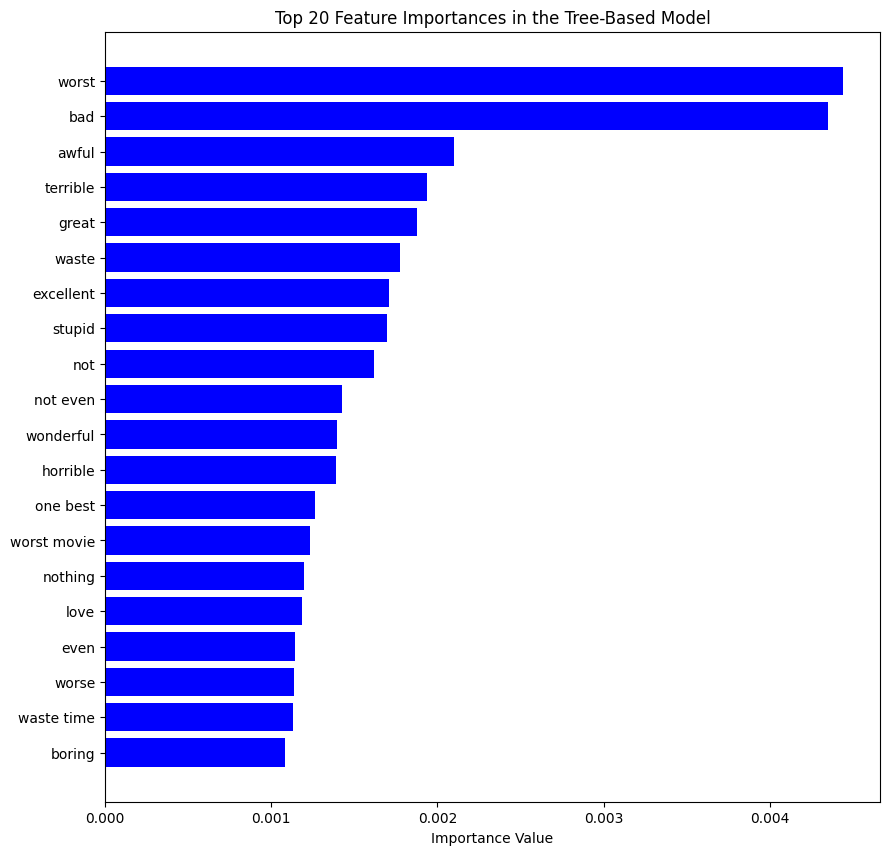

In [ ]:
rf_model = RandomForestClassifier(random_state=42).fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(rf_model, vectorizer_lemma_ngrams, top_n=20)

## CatBoost

In [ ]:
cb_results = train_and_evaluate_model(CatBoostClassifier(random_state=42, verbose=False, learning_rate = 0.1), datasets=prepared_data)

for key, value in cb_results.items():
    print(f"Set: {key}, Training Time: {value['train_time']:.2f} seconds, Train Accuracy: {value['train_accuracy']:.4f}, "
          f"Test Accuracy: {value['test_accuracy']:.4f}, Test F1 Score: {value['test_f1']:.4f}")

NameError: name 'train_and_evaluate_model' is not defined

In [ ]:
catboost_model = CatBoostClassifier(random_state=42, verbose=False, learning_rate = 0.1).fit(X_train_lemma_ngrams, y_train_lemma_ngrams)
plot_feature_importances(catboost_model, vectorizer_lemma_ngrams, top_n=20)

NameError: name 'CatBoostClassifier' is not defined

## Model Choice

* The lemmatized data with N-grams vectorization has consistently exhibited best results with all models. This performance comes at the cost of high dimensionality and longer training times. 
* Out of the four machine learning algorithms, logistic regression and linear SVC performed the best. 
* The logistic regression algorithm showed the highest test accuracy of 0.9015 in its baseline model. However, when the model was tuned for hyperparameters and cross-validated, the test performance slightly dropped to 0.9003.
* The linear SVC algorithm performed about the same as the logistic regression model. Although slightly lower than the in the baseline logistic regression model, through hyperparameter tuning we were able to obtain the highest test accuracy of 0.9005 for the linear SVC model. However, what is distinctly different, is how much time it took for the algorithm to train. It took 10 times shorter to train the Linear SVC model on the largest dataset (lemmatized with n-grams vectorization) than to train the logisitc regression model on the same dataset. This was especially notieable with hyperparameter tuning, which took 2 hours for logistic regression and 2 minutes for Linear SVC.
* Given this drastic difference in training times with comparable performance, I would choose the tuned Linear SVC model as the best model. 
* For further steps in this study, I would suggest implementing additional preprocessing steps (such as spell-checking), different libraries, as well as exploring deep learning models such as RNNs. Due to time constraints and hardware limitations, this study only explored traditional ML models.

# Appendix

Here's a little experiment with data cleaning. I will remove "movie" and "film" from the corpus and see if that increases the performance of the LinearSVC model.

In [ ]:
class TextPreprocessor:
    def __init__(self, use_lemmatization=True, vectorization_type=None):
        self.use_lemmatization = use_lemmatization
        self.vectorization_type = vectorization_type
        self.stop_words = set(stopwords.words('english')).union({'movie', 'movies', 'film', 'films'}) - {'not'}
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if not use_lemmatization else None
        self.vectorizer = None
        self.rare_words = None
        # Define a dictionary for contraction expansions
        self.contraction_mapping = {
            r"\bdidn't\b": "did not", r"\bdon't\b": "do not",
            r"\bwasn't\b": "was not", r"\bisn't\b": "is not",
            r"\bweren't\b": "were not", r"\bare't\b": "are not",
            r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
            r"\bcouldn't\b": "could not", r"\bcan't\b": "can not",
            r"\bain't\b": "am not", r"\bdoesn't\b": "does not",
            r"\bshouldn't\b": "should not", r"\bhadn't\b": "had not",
            r"\bhaven't\b": "have not", r"\bhasn't\b": "has not",
            r"\bmustn't\b": "must not"
        }

    def preprocess(self, data, fit_vectorizer=False):
        if 'sentiment' in data.columns:
            y = data['sentiment'].map({'negative': 0, 'positive': 1})
        else:
            y = None
        
        if self.rare_words is None:
            self._calculate_rare_words(data['review'])

        X_cleaned = data['review'].apply(self._clean_text)

        if self.vectorization_type and fit_vectorizer:
            self.vectorizer = self._get_vectorizer()
            X_vectorized = self.vectorizer.fit_transform(X_cleaned)
        elif self.vectorization_type:
            X_vectorized = self.vectorizer.transform(X_cleaned)
        else:
            X_vectorized = X_cleaned

        return X_vectorized, y, self.vectorizer if fit_vectorizer else None

    def _get_vectorizer(self):
        if self.vectorization_type.lower() == 'ngrams':
            return CountVectorizer(ngram_range=(1, 3), stop_words=list(self.stop_words))
        elif self.vectorization_type.lower() == 'tf-idf':
            return TfidfVectorizer(stop_words=list(self.stop_words))
        else:
            raise ValueError("Invalid vectorization type specified.")

    def _initial_preprocess(self, text):
        # Expand contractions, case-insensitive
        for contraction, expanded in self.contraction_mapping.items():
            text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"(n't|'d|'ll|'m|'re|'s|'ve|')", '', text, flags=re.IGNORECASE)
        tokens = word_tokenize(text)
        tokens = [word for word, pos in pos_tag(tokens) if pos not in ['NNP', 'NNPS']]
        tokens = [re.sub(r'\W+', ' ', word) for word in tokens if not word.isnumeric()]
        return [word.lower() for word in tokens]

    def _calculate_rare_words(self, reviews):
        all_words = [word for review in reviews for word in self._initial_preprocess(review)]
        word_counts = Counter(all_words)
        self.rare_words = {word for word, count in word_counts.items() if count == 1}

    def _clean_text(self, text):
        tokens = self._initial_preprocess(text)
        tokens = [word for word in tokens if word not in self.rare_words and word not in self.stop_words and len(word) > 2]

        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)
    
preprocessor = TextPreprocessor(use_lemmatization=True, vectorization_type='ngrams')
X_train, y_train, _ = preprocessor.preprocess(train, fit_vectorizer=True)
X_test, y_test, _ = preprocessor.preprocess(test, fit_vectorizer=False)
model = LinearSVC(random_state=42, C=0.01, max_iter=5000).fit(X_train, y_train)
print(f'Accuracy of the LinearSVC model after removing words "movie" and "film": {model.score(X_test, y_test): .4f}')

In [ ]:
import spacy

spacy_stop_words = spacy.load('en_core_web_sm').Defaults.stop_words

class TextPreprocessor:
    def __init__(self, use_lemmatization=True, vectorization_type=None):
        self.use_lemmatization = use_lemmatization
        self.vectorization_type = vectorization_type
        self.stop_words = set(stopwords.words('english')).union(spacy_stop_words) - {'not'}
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if not use_lemmatization else None
        self.vectorizer = None
        self.rare_words = None
        # Define a dictionary for contraction expansions
        self.contraction_mapping = {
            r"\bdidn't\b": "did not", r"\bdon't\b": "do not",
            r"\bwasn't\b": "was not", r"\bisn't\b": "is not",
            r"\bweren't\b": "were not", r"\bare't\b": "are not",
            r"\bwouldn't\b": "would not", r"\bwon't\b": "will not",
            r"\bcouldn't\b": "could not", r"\bcan't\b": "can not",
            r"\bain't\b": "am not", r"\bdoesn't\b": "does not",
            r"\bshouldn't\b": "should not", r"\bhadn't\b": "had not",
            r"\bhaven't\b": "have not", r"\bhasn't\b": "has not",
            r"\bmustn't\b": "must not"
        }

    def preprocess(self, data, fit_vectorizer=False):
        if 'sentiment' in data.columns:
            y = data['sentiment'].map({'negative': 0, 'positive': 1})
        else:
            y = None
        
        if self.rare_words is None:
            self._calculate_rare_words(data['review'])

        X_cleaned = data['review'].apply(self._clean_text)

        if self.vectorization_type and fit_vectorizer:
            self.vectorizer = self._get_vectorizer()
            X_vectorized = self.vectorizer.fit_transform(X_cleaned)
        elif self.vectorization_type:
            X_vectorized = self.vectorizer.transform(X_cleaned)
        else:
            X_vectorized = X_cleaned

        return X_vectorized, y, self.vectorizer if fit_vectorizer else None

    def _get_vectorizer(self):
        if self.vectorization_type.lower() == 'ngrams':
            return CountVectorizer(ngram_range=(1, 3), stop_words=list(self.stop_words))
        elif self.vectorization_type.lower() == 'tf-idf':
            return TfidfVectorizer(stop_words=list(self.stop_words))
        else:
            raise ValueError("Invalid vectorization type specified.")

    def _initial_preprocess(self, text):
        # Expand contractions, case-insensitive
        for contraction, expanded in self.contraction_mapping.items():
            text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
        text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"(n't|'d|'ll|'m|'re|'s|'ve|')", '', text, flags=re.IGNORECASE)
        tokens = word_tokenize(text)
        tokens = [word for word, pos in pos_tag(tokens) if pos not in ['NNP', 'NNPS']]
        tokens = [re.sub(r'\W+', ' ', word) for word in tokens if not word.isnumeric()]
        return [word.lower() for word in tokens]

    def _calculate_rare_words(self, reviews):
        all_words = [word for review in reviews for word in self._initial_preprocess(review)]
        word_counts = Counter(all_words)
        self.rare_words = {word for word, count in word_counts.items() if count == 1}

    def _clean_text(self, text):
        tokens = self._initial_preprocess(text)
        tokens = [word for word in tokens if word not in self.rare_words and word not in self.stop_words and len(word) > 2]

        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        else:
            tokens = [self.stemmer.stem(word) for word in tokens]

        return ' '.join(tokens)
    
preprocessor = TextPreprocessor(use_lemmatization=True, vectorization_type='ngrams')
X_train, y_train, _ = preprocessor.preprocess(train, fit_vectorizer=True)
X_test, y_test, _ = preprocessor.preprocess(test, fit_vectorizer=False)
model = LinearSVC(random_state=42, C=0.01, max_iter=5000).fit(X_train, y_train)
print(f'Accuracy of the LinearSVC model after removing stop words from SpaCy: {model.score(X_test, y_test): .4f}')